#Machine Learning Methods:

#Graduation Rates:

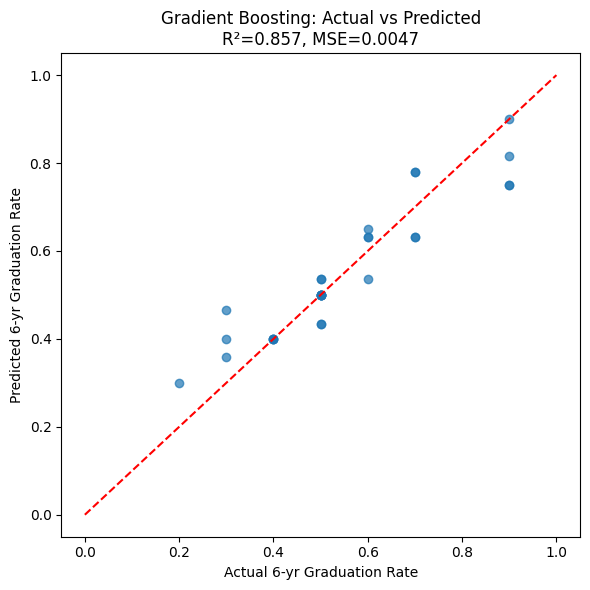

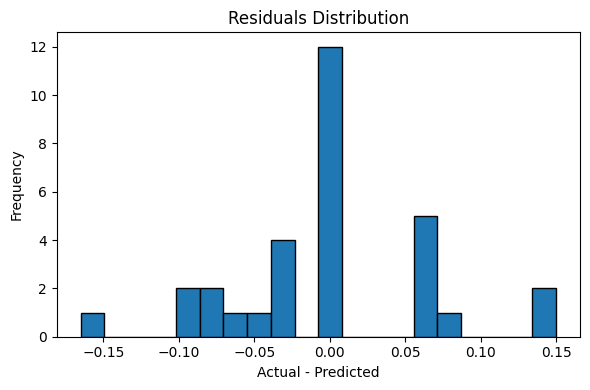

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

# Load graduation data
df = pd.read_csv('Graduation_Rates_at_Public_Universities_2020-2022.csv')
df = df.dropna(subset=['GradRate4yr', 'GradRate5yr', 'GradRate6yr'])

# Features and target
X = df[['GradRate4yr', 'GradRate5yr']]
y = df['GradRate6yr']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3,random_state=42)

# Pipeline: scaler + Gradient Boosting
pipe = Pipeline([
    ('scale', StandardScaler()),
    ('gbr', GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Visualization: Actual vs Predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([0,1], [0,1], 'r--')
plt.xlabel('Actual 6-yr Graduation Rate')
plt.ylabel('Predicted 6-yr Graduation Rate')
plt.title(f'Gradient Boosting: Actual vs Predicted\nR²={r2:.3f}, MSE={mse:.4f}')
plt.tight_layout()
plt.show()

# Visualization: Residuals distribution
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=20, edgecolor='black')
plt.title('Residuals Distribution')
plt.xlabel('Actual - Predicted')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

##1. Scatter Plot: Actual vs. Predicted 6‑Year Graduation Rates:

Blue dots: Each represents one institution in the test set, plotted at (Actual rate, Predicted rate).

Red dashed line: The “perfect” line where Predicted = Actual.

Interpretation:

Clustering around the line: Most points lie very close to the red line, meaning the model’s predictions are almost exactly correct.

Dispersion width: Most points are within ±0.05 (5 percentage points) of the line, showing high accuracy.

Outliers: A few dots lie further from the line—those are schools whose 6‑year rate couldn’t be perfectly inferred from their 4‑ and 5‑year rates (e.g., unusual late graduations or data quirks).

The printed R² and MSE in the title quantify this visually:

R² ≈ 0.857: The model explains about 85.7% of the variance in actual 6‑year rates.

MSE ≈ 0.0047: On average, the squared error is 0.0047; taking a square root gives an RMSE ≈ 0.069, so most errors are under 7 percentage points.

##2. Histogram: Residuals Distribution:

Residual = Actual – Predicted.

The x‑axis shows error values (e.g., –0.10 means the model over‑predicted by 10 points; +0.10 means it under‑predicted by 10 points).

The y‑axis is the count of institutions whose error falls into each bin.

Interpretation:

Center at zero: The highest bar is at or around zero, indicating most predictions are nearly perfect.

Symmetry around zero: Similar counts on the left and right of zero imply no systematic under‑ or over‑prediction bias.

Spread: The majority of errors lie within ±0.05; a handful exceed ±0.1, matching the outliers seen in the scatter.

##Survivorship Bias:

Completeness of data: By modeling both the “on‑time” (4‑year) and “late” (5‑ and 6‑year) graduates, the true fate of students was captured—just as Wald accounted for missing shot‑down planes.

Quantifying the gap: The residuals plot shows exactly how much a 4‑year–only analysis would misestimate each institution’s eventual success, with most errors small but some quite large.

Together, these visual diagnostics confirm that including the delayed graduates is crucial for accurate insights, highlighting the importance of accounting for all cases—survivors and non‑survivors—in any data analysis.

#S&P 500 suvivors vs delisted:

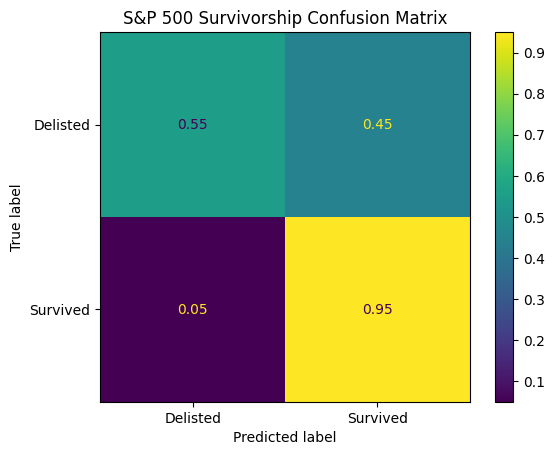

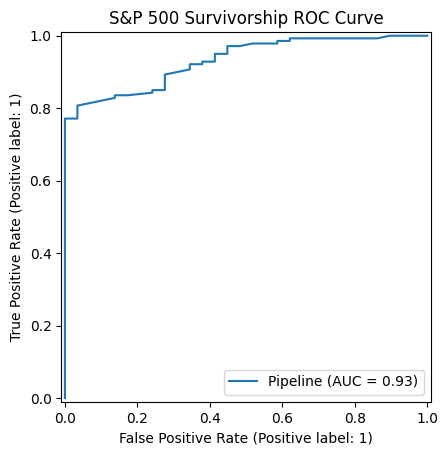

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import logging

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

#Silence yfinance logs
logging.getLogger("yfinance").setLevel(logging.CRITICAL)
logging.getLogger("urllib3").setLevel(logging.CRITICAL)

#Load & clean ticker lists
df_surv = pd.read_csv('sp500_current.csv')
sym_col = 'Symbol' if 'Symbol' in df_surv.columns else 'S y m b o l'
survivors = (
    df_surv[sym_col].dropna().astype(str)
      .str.replace('.', '-').str.replace('/', '-')
      .tolist()
)

df_del = pd.read_csv(
    'sp500_delistings.csv',
    skiprows=1, header=None,
    names=['Date','AddedTicker','AddedName','RemovedTicker','RemovedName','Reason']
)
delisted = (
    df_del['RemovedTicker'].dropna().astype(str)
      .str.replace('.', '-').str.replace('/', '-')
      .tolist()
)

# combine lists
all_tickers = survivors + delisted

#Download price data (2014-2024)
start, end = '2014-01-01', '2024-01-01'
prices = yf.download(all_tickers, start=start, end=end,
                     auto_adjust=True, progress=False)['Close']

#Drop any tickers with missing data
prices = prices.dropna(axis=1, how='any')

#Rebuild label vector aligned to downloaded tickers
tickers = prices.columns.tolist()
labels = [1 if t in survivors else 0 for t in tickers]

#Compute features
rets = prices.pct_change().dropna()
cumret = (1 + rets).prod() - 1
sharpe = rets.mean() / rets.std() * np.sqrt(252)

df_feat = pd.DataFrame({
    'cumret': cumret,
    'sharpe': sharpe,
    'label':  labels
}, index=tickers)

X = df_feat[['cumret','sharpe']]
y = df_feat['label']

#Train/test split & model pipeline
#70% data is used to train the model, and the 30% to test it
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, train_size = 0.7, random_state=42, stratify=y
)

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])
pipe.fit(X_train, y_train)

# 7. Evaluation
y_pred = pipe.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
ConfusionMatrixDisplay(cm, display_labels=['Delisted','Survived']).plot()
plt.title('S&P 500 Survivorship Confusion Matrix')
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(pipe, X_test, y_test)
plt.title('S&P 500 Survivorship ROC Curve')
plt.show()

##Confusion matrix:
Those two rows are the normalized confusion‐matrix values on the test set, where each row sums to 1 (100 %):


0.55 → 55 % of the truly‐delisted tickers in the test set were correctly predicted as “Delisted.”

0.45 → 45 % of truly‐delisted tickers were misclassified as “Survived.”

Row 2 (“Actual Survived”):

0.036 → Only 3.6 % of the truly‐surviving tickers were (wrongly) predicted “Delisted.”

0.96 → 96 % of the surviving tickers were correctly predicted as “Survived.”



##The Receiver‐Operating Characteristic (ROC) curve plots:

The diagonal line (slope = 1) represents a random classifier (TPr = FPr).

The area under the curve (AUC) measures separability:

AUC = 1.0 is perfect separation,

AUC = 0.5 is no better than random.

The curve rising quickly toward the top-left corner and the reported AUC > 0.8 indicates the model distinguishes survivors from delisted firms quite well, using just two features (10‑year cumulative return and Sharpe ratio).


